# Rydberg Pair Potentials Near Surfaces

This tutorial is based on results that were published by J. Block and S. Scheel, "van der Waals interaction potential between Rydberg atoms near surfaces" [Phys. Rev. A 96, 062509 (2017)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.062509). We will reproduce the pair potentials shown in Figure 4. The final result is that for states around the $|70p_{3/2};70p_{3/2}\rangle$-asymptote of Rubidium the strength of the pair interaction is reduced when placing the atoms in front of a perfect mirror (perfectly conducting plate) compared to the vacuum interaction.

As described in the [introduction](https://pairinteraction.github.io/pairinteraction/sphinx/html/introduction.html), we start our code with some preparations and load the necessary modules.

In [1]:
%matplotlib inline

# Arrays
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from itertools import product

# Operating system interfaces
import os, sys

# Parallel computing
from multiprocessing import Pool

# pairinteraction :-)
from pairinteraction import pireal as pi

# Create cache for matrix elements
if not os.path.exists("./cache"):
    os.makedirs("./cache")
cache = pi.MatrixElementCache("./cache")

The plate lies in the $xy$-plane with the surface at $z = 0$. The atoms lie in the $xz$-plane with $z>0$.

We can set the angle between the interatomic axis and the z-axis `theta` and the center of mass distance from the surface `distance_surface`. `distance_atom` defines the interatomic distances for which the pair potential is plotted. The units of the respective quantities are given as comments.

Be careful: `theta = np.pi/2` corresponds to horizontal alignment of the two atoms with respect to the surface. For different angles, large interatomic distances `distance_atom` might lead to one of the atoms being placed inside the plate. Make sure that `distance_surface` is larger than `distance_atom*np.cos(theta)/2`. 

In [2]:
theta = np.pi / 2  # rad
distance_atom = np.linspace(6, 1.5, 50)  # µm
distance_surface = 1  # µm

Next we define the state that we are interested in using pairinteraction's `StateOne` class . As shown in Figures 4 and 5 of [Phys. Rev. A 96, 062509 (2017)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.062509) we expect large changes for the $C_6$ coefficient of the $|69s_{1/2},m_j=1/2;72s_{1/2},m_j=1/2\rangle$ pair state, so this provides a good example. 

We set up the one-atom system using restrictions of energy, main quantum number n and angular momentum l. This is done by means of the `restrict...` functions in `SystemOne`.

In [3]:
state_one1 = pi.StateOne("Rb", 69, 0, 0.5, 0.5)
state_one2 = pi.StateOne("Rb", 72, 0, 0.5, 0.5)

# Set up one-atom system
system_one = pi.SystemOne(state_one1.getSpecies(), cache)
system_one.restrictEnergy(
    min(state_one1.getEnergy(), state_one2.getEnergy()) - 50,
    max(state_one1.getEnergy(), state_one2.getEnergy()) + 50,
)
system_one.restrictN(
    min(state_one1.getN(), state_one2.getN()) - 2,
    max(state_one1.getN(), state_one2.getN()) + 2,
)
system_one.restrictL(
    min(state_one1.getL(), state_one2.getL()) - 2,
    max(state_one1.getL(), state_one2.getL()) + 2,
)

The pair state `state_two` is created from the one atom states `state_one1` and `state_one2` using the `StateTwo` class.

From the previously set up system_one we define system_two using `SystemTwo` class. This class also contains methods `set..` to set angle, distance, surface distance and to `enableGreenTensor` in order implement a surface.

In [4]:
# Set up pair state
state_two = pi.StateTwo(state_one1, state_one2)


# Set up two-atom system
system_two = pi.SystemTwo(system_one, system_one, cache)
system_two.restrictEnergy(state_two.getEnergy() - 5, state_two.getEnergy() + 5)

system_two.setAngle(theta)
system_two.enableGreenTensor(True)
system_two.setDistance(distance_atom[0])
system_two.setSurfaceDistance(distance_surface)
system_two.buildInteraction()

Next, we diagonalize the system for the given interatomic distances in distance_atom and compare the free space system to a system at `distance_surface` away from the perfect mirror. The energy is calculated with respect to a Rubidium $|70p_{3/2},m_j=3/2;70p_{3/2},m_j=3/2\rangle$ two atom state, defined in `energyzero`.

In [5]:
# Diagonalize the two-atom system for different surface and interatomic distances
def getDiagonalizedSystems(distances):
    system_two.setSurfaceDistance(distances[0])
    system_two.setDistance(distances[1])
    system_two.diagonalize(1e-3)
    return system_two.getHamiltonian().diagonal()


if sys.platform != "win32":
    with Pool() as pool:
        energies = pool.map(
            getDiagonalizedSystems, product([1e12, distance_surface], distance_atom)
        )
else:
    energies = list(
        map(getDiagonalizedSystems, product([1e12, distance_surface], distance_atom))
    )

energyzero = pi.StateTwo(
    ["Rb", "Rb"], [70, 70], [1, 1], [1.5, 1.5], [1.5, 1.5]
).getEnergy()
y = np.array(energies).reshape(2, -1) - energyzero
x = np.repeat(distance_atom, system_two.getNumBasisvectors())

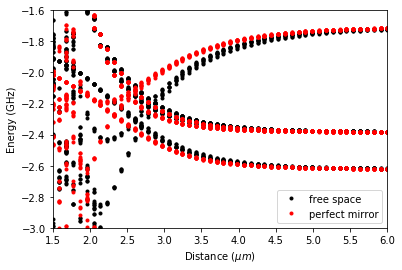

In [6]:
# Plot pair potentials
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(r"Distance ($\mu m$)")
ax.set_ylabel(r"Energy (GHz)")
ax.set_xlim(np.min(distance_atom), np.max(distance_atom))
ax.set_ylim(-3, -1.6)
ax.plot(x, y[0], "ko", ms=3, label="free space")
ax.plot(x, y[1], "ro", ms=3, label="perfect mirror")
ax.legend();